In [1]:
from tqdm import tqdm
from time import sleep

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datasets import load_dataset
from pinecone import Pinecone, ServerlessSpec
from sentence_transformers import SentenceTransformer
from pinecone_text.sparse import BM25Encoder

In [4]:
import torch
import os

In [5]:
from UDCUtils import UDCUtils
utils = UDCUtils()

pinecone_api_key = utils.get_pinecone_api_key()

In [6]:
pinecone_api_key

'fcd3e082-248a-4a31-b1c0-80c255c9d687'

In [7]:
pinecone = Pinecone(api_key=pinecone_api_key)
help(pinecone.delete_index)

Help on method delete_index in module pinecone.control.pinecone:

delete_index(name: str, timeout: Optional[int] = None) method of pinecone.control.pinecone.Pinecone instance
    Deletes a Pinecone index.

    Deleting an index is an irreversible operation. All data in the index will be lost.
    When you use this command, a request is sent to the Pinecone control plane to delete
    the index, but the termination is not synchronous because resources take a few moments to
    be released.

    You can check the status of the index by calling the `describe_index()` command.
    With repeated polling of the describe_index command, you will see the index transition to a
    `Terminating` state before eventually resulting in a 404 after it has been removed.

    :param name: the name of the index.
    :type name: str
    :param timeout: Number of seconds to poll status checking whether the index has been deleted. If None,
        wait indefinitely; if >=0, time out after this many seconds;

In [8]:
index_name = utils.create_dlai_index_name("dev-002")
#print(index_name)
index_name = index_name[:-3]
#print(index_name)
if index_name in [index['name'] for index in pinecone.list_indexes()]:
    print(f"{index_name} is an existing index. Kindly delete it.")
    pinecone.delete_index(index_name)

dev-002-118d1-7f10-4f3c-a4a6-41d7caaf84cc is an existing index. Kindly delete it.


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device!='cuda':
    print("Sorry, cuda is not available. Proceeding ahead with CPU.")

Sorry, cuda is not available. Proceeding ahead with CPU.


In [10]:
pinecone.create_index(
    name=index_name,
    metric='dotproduct',
    dimension=512,
    spec=ServerlessSpec(cloud='aws', region='us-east-1')
)

PineconeApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'content-type': 'text/plain; charset=utf-8', 'access-control-allow-origin': '*', 'vary': 'origin,access-control-request-method,access-control-request-headers', 'access-control-expose-headers': '*', 'x-pinecone-api-version': '2024-07', 'X-Cloud-Trace-Context': '01f23b91d12ae26148435e9aa51aafa9', 'Date': 'Fri, 16 Aug 2024 06:12:18 GMT', 'Server': 'Google Frontend', 'Content-Length': '85', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000'})
HTTP response body: {"error":{"code":"ALREADY_EXISTS","message":"Resource  already exists"},"status":409}


In [12]:
index = pinecone.Index(index_name)

In [ ]:
help(load_dataset)

In [ ]:
#pip install ipywidgets==7.7.2

In [11]:
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

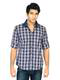

In [15]:
images = fashion['image']
images[0]

In [16]:
metadata = fashion.remove_columns('image')
metadata[0]

{'id': 15970,
 'gender': 'Men',
 'masterCategory': 'Apparel',
 'subCategory': 'Topwear',
 'articleType': 'Shirts',
 'baseColour': 'Navy Blue',
 'season': 'Fall',
 'year': 2011.0,
 'usage': 'Casual',
 'productDisplayName': 'Turtle Check Men Navy Blue Shirt'}

In [17]:
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


### Create sparse vector using BM25Encoder

In [18]:
bm25encoder = BM25Encoder()
bm25encoder.fit(metadata['productDisplayName'])
metadata['productDisplayName'][0]

[nltk_data] Downloading package stopwords to /Users/sana/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/44072 [00:00<?, ?it/s]

'Turtle Check Men Navy Blue Shirt'

In [19]:
bm25encoder.encode_queries(metadata['productDisplayName'][0])
bm25encoder.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

### Create dense vector using CLIP

In [22]:
pip install ipywidgets==7.7.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [23]:
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)

#check the dim
clip_vector = model.encode(metadata['productDisplayName'][0])
clip_vector.shape

(512,)

In [24]:
len(fashion)

44072

In [25]:
batch_size = 100
fashion_data_num = 1000

for i in tqdm(range(0, min(fashion_data_num,len(fashion)), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    
    # extract image batch
    img_batch = images[i:i_end]
    
    # create sparse using bm25encoder for metadata
    sparse_embeds = bm25encoder.encode_documents([text for text in meta_batch])
    
    # create dense vectors using clip model for images
    dense_embeds = model.encode(img_batch).tolist()
    
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

100%|███████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

In [26]:
query = "navy blue shirt for women"

sparse_vec = bm25encoder.encode_queries(query)
dense_vec = model.encode(query).tolist()

result = index.query(
    top_k=10,
    vector=dense_vec,
    sparse_vector=sparse_vec,
    include_metadata=True
)

In [31]:
imgs = []
for r in result["matches"]:
    #print(r)
    imgs.append(images[int(r["id"])])

In [32]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


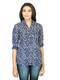
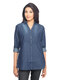
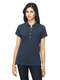
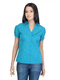
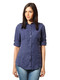
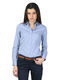
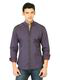
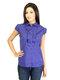
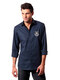
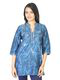

In [33]:
display_result(imgs)

In [35]:
for r in result["matches"]:
    print(r["metadata"]["productDisplayName"])

Scullers For Her Women Printed Navy Blue Shirt
Scullers For Her Women Blue Top
Scullers For Her Navy Blue T-shirt
Jealous 21 Women Teal Shirt
United Colors of Benetton Women Purple Shirt
Arrow Woman Blue Shirt
John Players Men Check Blue Shirt
Arrow Woman Blue Shirt
John Players Men Navy Blue Shirt
Aneri Women Ashna Blue Kurta


### Scaling the hybrid search

In [36]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

In [38]:
search_query = "navy blue shirt for women"

dense = model.encode(search_query).tolist()
sparse = bm25encoder.encode_queries(search_query)

#alpha is at extreme level, for a very dense vector
hdense, hsparse = hybrid_scale(dense, sparse, 1)

response = index.query(
    top_k=3,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)

In [39]:
imgs = []
for res in response["matches"]:
    imgs.append(images[int(res["id"])])

In [40]:
len(imgs)

3


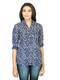
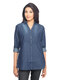
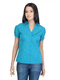

In [41]:
display_result(imgs)

In [44]:
for r in response['matches']:
    print(r["metadata"]["productDisplayName"])

Scullers For Her Women Printed Navy Blue Shirt
Scullers For Her Women Blue Top
Jealous 21 Women Teal Shirt


### More sparse hybrid search

In [45]:
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)

response = index.query(
    top_k=3,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)

In [47]:
imgs = [images[int(r["id"])] for r in response["matches"]]


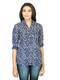
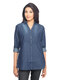
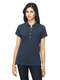

In [48]:
display_result(imgs)

In [49]:
for r in response["matches"]:
    print(r["metadata"]["productDisplayName"])

Scullers For Her Women Printed Navy Blue Shirt
Scullers For Her Women Blue Top
Scullers For Her Navy Blue T-shirt


### experiment with value of alpha

In [51]:
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.5)

response = index.query(
    top_k=10,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)


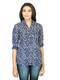
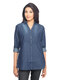
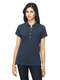
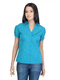
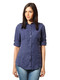
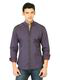
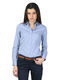
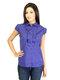
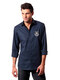
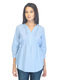

In [52]:
imgs = [images[int(r["id"])] for r in response["matches"]]
display_result(imgs)

In [54]:
for r in response["matches"]:
    print(f"{r["score"]}: {r["metadata"]["productDisplayName"]}")

30.4289761: Scullers For Her Women Printed Navy Blue Shirt
29.1198521: Scullers For Her Women Blue Top
28.6167984: Scullers For Her Navy Blue T-shirt
28.5936699: Jealous 21 Women Teal Shirt
28.2291508: United Colors of Benetton Women Purple Shirt
28.2055969: John Players Men Check Blue Shirt
28.1473541: Arrow Woman Blue Shirt
27.9396362: Arrow Woman Blue Shirt
27.8888988: John Players Men Navy Blue Shirt
27.7596169: Lee Women Paula Blue Top
